<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">AG Dynamics of the Earth</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Jupyter notebooks</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
</tr>
</table>

# Numerical methods: 11. Finite differences 
## Advection-diffusion-reaction equation in 1D
## Explicit scheme
----
*Georg Kaufmann,
Geophysics Section,
Institute of Geological Sciences,
Freie Universität Berlin,
Germany*

----
In this notebook, we solve a simple **transient advection-diffusion-reaction equation** in one dimension,
using an **explicit** numerical method.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from ipywidgets import interactive
import ipywidgets as widgets

----
## Advection-diffusion-reaction equation

We come back to the full transient advection-diffusion-reaction equation in 1D:
$$
\fbox{$
\frac{\partial c(x,t)}{\partial t} 
= - v \frac{\partial c(x,t)}{\partial x}
+ D \frac{\partial^2 c(x,t)}{\partial x^2}
- \lambda c(x,t)
$}
$$
with
- $x$ [m]  position,
- $t$ [s] time,
- $c$ [-] normalized concentration,
- $v$ [m/s]  velocity,
- $D$ [m$^2$/s] diffusion,
- $\lambda$ [1/s] decay constant.

The **initial condition** is:
$$
c(x,t=0) = c_0(x,0)
$$

----
## Gaussian function

We define the `Gaussian` function with mean $\mu$ and standard deviation $\sigma$:
$$
c(x,t) = e^{-\frac{(x-\mu)^2}{\sigma^2}}
$$
which is a solution of the transient advection equation.

In [2]:
def gaussian(x,mu=2.,sigma=1.):
    # Gauss curve
    f = np.exp(-(x-mu)**2/(sigma)**2)
    return f

def rectangle(x,mu=2.,sigma=1.):
    # rectangle
    f = np.where(np.abs(x-mu/sigma)<1,1,0)
    return f

def triangle(x,mu=2.,sigma=1.):
    # triangle
    f = np.zeros_like(x)
    for i in range(len(x)):
        if (x[i]>=(mu-sigma) and x[i] <= mu):
            x1 = mu-sigma; y1=0.
            x2 = mu;y2=1.
            f[i] = y1 + (y2-y1)/(x2-x1)*(x[i]-x1)
        if (x[i]>=mu and x[i] <= mu+sigma):
            x1 = mu; y1=1.
            x2 = mu+sigma;y2=0.
            f[i] = y1 + (y2-y1)/(x2-x1)*(x[i]-x1)
    return f

In [3]:
xstep = 141
x,dx = np.linspace(-2,12,xstep,retstep=True)   # m
print('dx: ',dx)

dx:  0.1


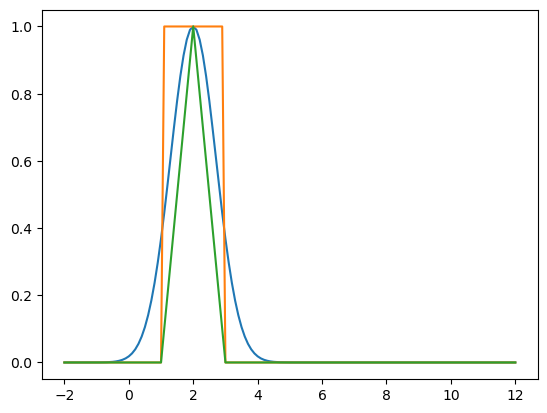

In [4]:
plt.plot(x,gaussian(x))
plt.plot(x,rectangle(x))
plt.plot(x,triangle(x))

----
## Numerical scheme

We use the forward-time centered space (FTCS), where the derivatives in the
transient advection equation are replaced by **forward differences in time** and 
**central differences is space**:
$$
\frac{c_{i}^{n+1}-c_{i}^{n}}{\Delta t}
=
-v \frac{c_{i+1}^{n}-c_{i-1}^{n}}{2 \Delta x}
+ D \frac{c_{i+1}^{n}-2 c_{i}^{n} + c_{i-1}^{n}}{\Delta x^2}
-\lambda c^n_i
$$
or solved for the next time step
$$
c_{i}^{n+1}
=
c_{i}^{n} 
-\frac{v \Delta t}{2 \Delta x} \left( c_{i+1}^{n}-c_{i-1}^{n} \right)
+ \frac{D \Delta t}{\Delta x^2} \left( c_{i+1}^{n}-2 c_{i}^{n} + c_{i-1}^{n} \right)
- \lambda c^n_i \Delta t
$$

<img src="images/PDE_FTCS.jpg" style="height:5cm;">

----
## Courant criteria
The `advective Courant number` is
$$
Co^{a} = \frac{v \Delta t}{\Delta x}
$$
and the `diffusive Courant number` is
$$
Co^{d} = \frac{D \Delta t}{\Delta x^2}
$$.

We solve for the time increments:
$$
\begin{array}{rcl}
\Delta t^{a} &<& \frac{\Delta x}{v} \\
\Delta t^{d} &<& \frac{\Delta x^2}{D}
\end{array}
$$

We use the smaller time increment...

----
## Parameter values and implementation

We define **advection velocity** $v$, diffusivity $D$, and decay constant $\lambda$
later in the function `AdvDiffReact(v,D,thalf)`.
We use the FTCS method:

In [5]:
def AdvDiffReact(v=0,D=0,thalf=1000,type_init=0,type_bc=0):
    # define time step from Courant criteria, use 0.1s if v=D=0
    dtadv = np.nan; dtdiff = np.nan
    if (D != 0):
        dtdiff = 0.2*dx**2/D
    if (v != 0):
        dtadv = 0.2*dx/v
    dt = np.nanmin([dtdiff,dtadv,0.1])
    # set time array
    time = np.arange(0,12,dt)
    # set alpha for diffusion and define thalf=100 as no decay
    alpha = D*dt/dx/dx
    if (thalf < 100):
        lamb  = np.log(2)/thalf
    else:
        lamb = 0.
    # set array for velocities
    nt = time.shape[0]
    nx = x.shape[0]
    U = np.zeros(nt*nx).reshape(nx,nt)
    u = np.zeros(nx)
    # initial step
    if (type_init==0):
        U[:,0] = gaussian(x)
    elif (type_init==1):
        U[:,0] = rectangle(x)
    elif (type_init==2):
        U[:,0] = triangle(x)
    if (type_bc==0):
        bc = 'fixed'
    elif (type_bc==1):
        bc = 'outflow'
    elif (type_bc==2):
        bc = 'cyclic'
    # time iteration
    for n in range(1,time.shape[0]):
        uold = U[:,n-1]
        for i in range(u.shape[0]):
            adv=0.;diff=0.;react=0.
            # left side
            if (i == 0):
                if (bc == 'no'):
                # no bc
                    u[i] = uold[i]
                elif (bc == 'outflow'):
                    # outflow bc
                    adv  = - v*dt/2/dx * (-3*uold[i] + 4*uold[i+1] - uold[i+2]) 
                    diff = alpha*(2*uold[i] - 5*uold[i+1] + 4*uold[i+2] - uold[i+3])
                elif (bc == 'cyclic'):
                    # cyclic bc
                    adv  = - v*dt/2/dx * (uold[i+1] - uold[u.shape[0]-1]) 
                    diff = alpha*(uold[i+1] - 2*uold[i] + uold[u.shape[0]-1])
            # right side
            elif (i == u.shape[0]-1):
                if (bc == 'no'):
                    # no bc
                    u[i] = uold[i]
                elif (bc == 'outflow'):
                    # outflow bc
                    adv  = - v*dt/2/dx * (uold[i-2] - 4*uold[i-1] + 3*uold[i]) 
                    diff = alpha*(-uold[i-3] + 4*uold[i-2] - 5*uold[i-1] + 2*uold[i])
                elif (bc == 'cyclic'):
                    # cyclic bc
                    adv  = - v*dt/2/dx * (uold[0] - uold[i-1]) 
                    diff = alpha*(uold[0] - 2*uold[i] + uold[i-1])
            else:
                adv  = - v*dt/2/dx * (uold[i+1] - uold[i-1]) 
                diff = alpha*(uold[i+1] - 2*uold[i] + uold[i-1])
            react = -lamb*uold[i]*dt
            u[i] = uold[i] + adv + diff + react
        U[:,n] = u
    # plot
    plt.figure(figsize=(10,6))
    plt.xlabel('x [m]')
    plt.ylabel('c')
    plt.grid(alpha=0.3)
    plt.title('FTCS method')
    for j in range(0,U.shape[1]):
        if (np.abs(time[j]%2) < 0.001):
            plt.plot(x,U[:,j],label='t='+str(round(time[j],1))+' s')
            plt.fill_between(x,U[:,j],0,linewidth=0,facecolor=(0.1,0.1,0.1,.1))
    plt.legend()
    return

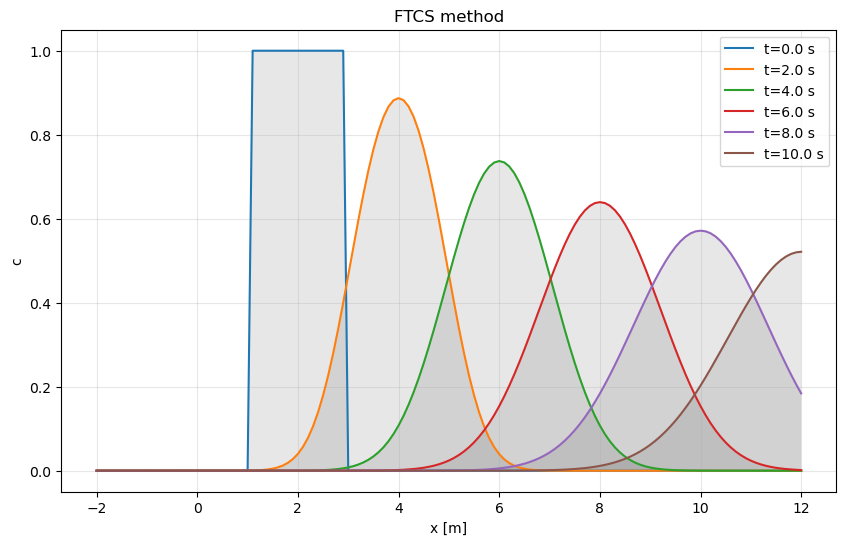

In [6]:
AdvDiffReact(v=1,D=0.1,thalf=1000,type_init=1,type_bc=1)

**Missing:** Explain use of boundary conditions ...

In [7]:
# call interactive module
interactive_plot = interactive(AdvDiffReact,
                               type_init=widgets.Dropdown(options=[('gaussian', 0),  
                               ('rectangular', 1),
                               ('triangular', 2)],value=0,description='Type:'),
                               type_bc=widgets.Dropdown(options=[('no', 0),  
                               ('outflow', 1),
                               ('cyclic', 2)],value=0,description='BC:'),
                               v=widgets.FloatSlider(min=0,max=1,step=0.1,value=1,description='v [m/s]'),
                               D=widgets.FloatSlider(min=0,max=0.5,step=0.02,value=0.2,description='D [m2/s]'),
                               thalf=widgets.FloatSlider(min=1,max=100,step=0.1,value=4,description='thalf [1/s]')
                               
                              )
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(FloatSlider(value=1.0, description='v [m/s]', max=1.0), FloatSlider(value=0.2, descripti…

----
Output for animation ...

In [8]:
def animate_AdvDiffReact(v=0,D=0,thalf=1000,type=0,bc='no'):
    # define time step from Courant criteria, use 0.1s if v=D=0
    dtadv = np.nan; dtdiff = np.nan
    if (D != 0):
        dtdiff = 0.2*dx**2/D
    if (v != 0):
        dtadv = 0.2*dx/v
    dt = np.nanmin([dtdiff,dtadv,0.1])
    # set time array
    time = np.arange(0,12,dt)
    # set alpha for diffusion and define thalf=100 as no decay
    alpha = D*dt/dx/dx
    if (thalf < 100):
        lamb  = np.log(2)/thalf
    else:
        lamb = 0.
    # set array for velocities
    nt = time.shape[0]
    nx = x.shape[0]
    U = np.zeros(nt*nx).reshape(nx,nt)
    u = np.zeros(nx)
    # initial step
    if (type==0):
        U[:,0] = gaussian(x)
    elif (type==1):
        U[:,0] = rectangle(x)
    elif (type==2):
        U[:,0] = triangle(x)
    # time iteration
    for n in range(1,time.shape[0]):
        uold = U[:,n-1]
        for i in range(u.shape[0]):
            adv=0.;diff=0.;react=0.
            # left side
            if (i == 0):
                if (bc == 'no'):
                # no bc
                    u[i] = uold[i]
                elif (bc == 'outflow'):
                    # outflow bc
                    adv  = - v*dt/2/dx * (-3*uold[i] + 4*uold[i+1] - uold[i+2]) 
                    diff = alpha*(2*uold[i] - 5*uold[i+1] + 4*uold[i+2] - uold[i+3])
                elif (bc == 'cyclic'):
                    # cyclic bc
                    adv  = - v*dt/2/dx * (uold[i+1] - uold[u.shape[0]-1]) 
                    diff = alpha*(uold[i+1] - 2*uold[i] + uold[u.shape[0]-1])
            # right side
            elif (i == u.shape[0]-1):
                if (bc == 'no'):
                    # no bc
                    u[i] = uold[i]
                elif (bc == 'outflow'):
                    # outflow bc
                    adv  = - v*dt/2/dx * (uold[i-2] - 4*uold[i-1] + 3*uold[i]) 
                    diff = alpha*(-uold[i-3] + 4*uold[i-2] - 5*uold[i-1] + 2*uold[i])
                elif (bc == 'cyclic'):
                    # cyclic bc
                    adv  = - v*dt/2/dx * (uold[0] - uold[i-1]) 
                    diff = alpha*(uold[0] - 2*uold[i] + uold[i-1])
            else:
                adv  = - v*dt/2/dx * (uold[i+1] - uold[i-1]) 
                diff = alpha*(uold[i+1] - 2*uold[i] + uold[i-1])
            react = -lamb*uold[i]*dt
            u[i] = uold[i] + adv + diff + react
        U[:,n] = u
    # plot

    for j in range(0,U.shape[1]):
        if (np.abs(time[j]%0.2) < 0.001):
            #print(j,time[j],name)
            plt.figure(figsize=(10,6))
            plt.xlim([-2,12])
            plt.ylim([-0.1,1.1])
            plt.xlabel('x [m]')
            plt.ylabel('c')
            plt.grid(alpha=0.3)
            plt.title('FTCS method')
            timestep = str(round(time[j],2)).zfill(4)
            name = '1DAdvDiffReact-'+timestep+'.jpg'
            plt.fill_between(x,U[:,j],0,linewidth=2,edgecolor=(0,0.2,1,1.0), facecolor=(0,0.2,1,.2),
                             label='t='+timestep+' s')
            plt.legend()
            plt.savefig('img/'+name)
            plt.close()
    print('... done')
    return

animate_AdvDiffReact(v=1,D=0.2,thalf=4,type=1,bc='outflow')
#animate_AdvDiffReact(v=1,D=0.04,thalf=1000,type=1,bc='cyclic')

... done


In [9]:
import matplotlib.animation as animation
import matplotlib.image as mpimg
from IPython.display import HTML
import glob
# list all png files in directory
imageList = sorted(glob.glob("img/1DAdvDiffReact-*.jpg"))
#print(imageList)

# define figure handle and empty array for list of figures    
fig,axs = plt.subplots(1,1,frameon=False,figsize=(10,5))
axs.set_axis_off()
ims = []
# loop over all figures, load them into image and apprend to array ims
for i in range(len(imageList)):
    image = mpimg.imread(imageList[i])
    img=plt.imshow(image)
    #print(i,getImageFromList(i))
    ims.append([img])
print('assembled images to list')
# create an animation object
ani = animation.ArtistAnimation(fig, ims, interval=500, blit=True, repeat=False) 
print('created animation sequence')
plt.close()
print('opening in web browser ...')
HTML(ani.to_jshtml())

assembled images to list
created animation sequence
opening in web browser ...


... done